In [1]:
import pickle
import matplotlib.pyplot as plt
import os
os.chdir("./..")
from docker_agent_logger.app.src.AI import *
import pandas as pd

2024-03-13 11:39:29.297221: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 11:39:29.582307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 11:39:29.582354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 11:39:29.634387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 11:39:29.744773: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 11:39:29.747021: I tensorflow/core/platform/cpu_feature_guard.cc:1

Using TensorFlow backend


In [22]:
df = pd.read_csv("data/cluster_metrics.txt")
df.cpu = df.cpu.apply(lambda x: x[:-1]).astype(int)*1e-9 #original: nCPU
df.memory = df.memory.apply(lambda x: x[:-2]).astype(int)*1.024e-3 #original: KiB

In [21]:
df.head()

,node,pod,container,cpu,memory
0,nodeserf2,dataread-deployment-7649bd9657-xpzdv,dataread,0.992950,2021.421056
1,nodeserf1,periodic-log-generator-job-gzqck,sim-gen,0.021773,209.154048
2,nodeserf1,periodic-log-generator-job-gzqck,logging-agent,1.000599,413.966336
3,nodeserf2,dataread-deployment-7649bd9657-xpzdv,dataread,0.992950,2021.421056
4,nodeserf1,periodic-log-generator-job-gzqck,logging-agent,1.000599,413.966336


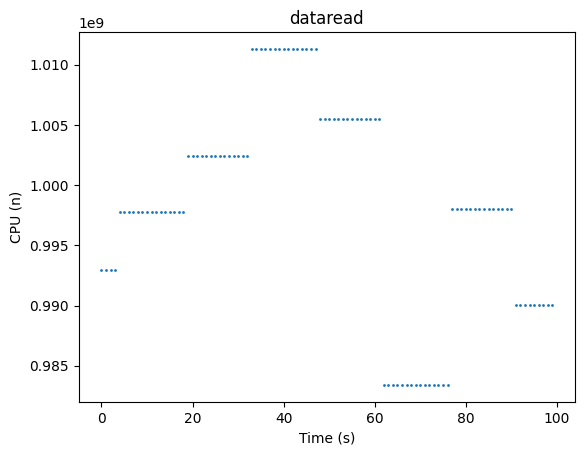

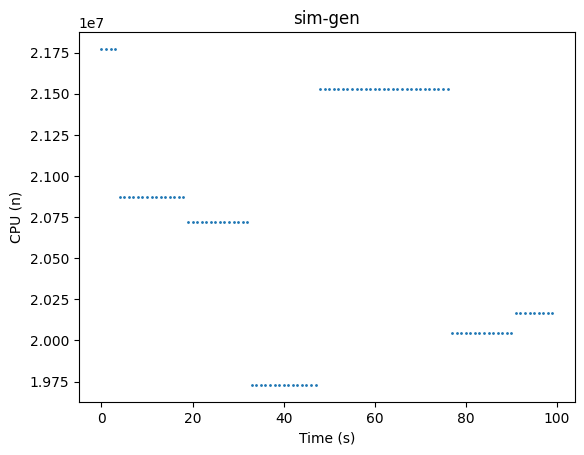

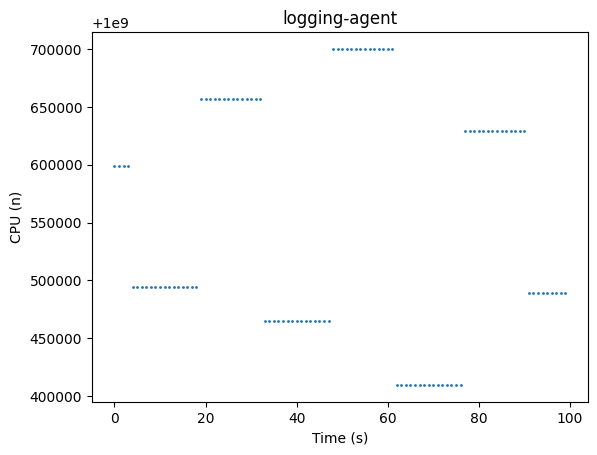

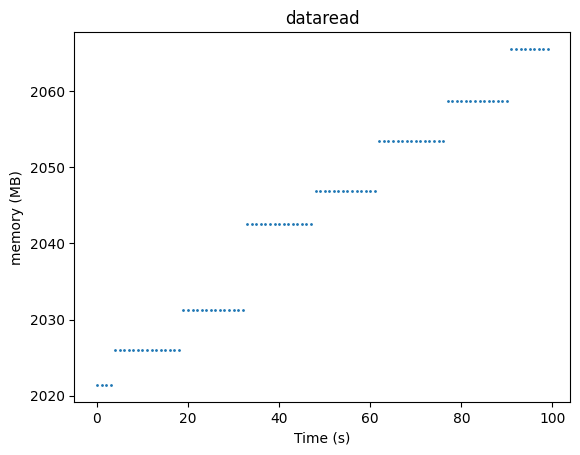

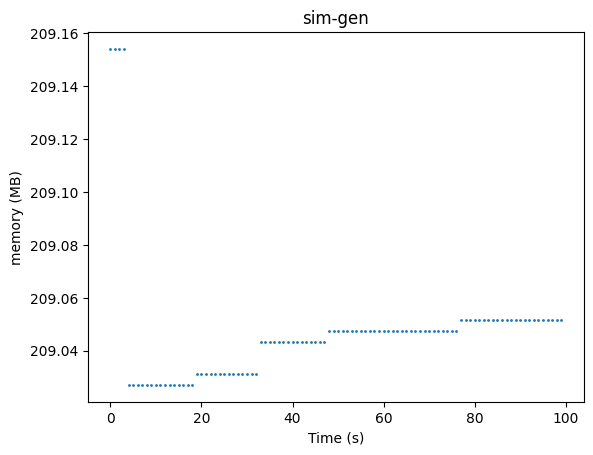

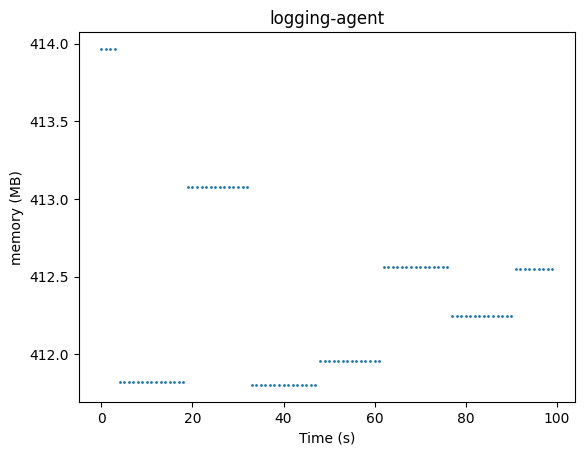

In [19]:
for container in df.container.unique():
    fig, ax = plt.subplots()
    cont_df = df[df.container == container]
    cont_df.reset_index(inplace=True)
    x = cont_df.index.values
    y = cont_df.cpu
    ax.title.set_text(container)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("CPU (n)")
    ax.scatter(x,y,s=1,zorder=1)

for container in df.container.unique():
    fig, ax = plt.subplots()
    cont_df = df[df.container == container]
    cont_df.reset_index(inplace=True)
    x = cont_df.index.values
    y = cont_df.memory
    ax.title.set_text(container)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("memory (MB)")
    ax.scatter(x,y,s=1,zorder=1)

In [261]:
!sshpass -p "lTLm#191" scp -r lucaserf@nodeserf2:/var/log/logging_data/ ./data/

Load key "/home/lucaserf/.ssh/wlslucaserf": Permission denied


In [262]:
df = pd.read_csv("data/logging_data/time.txt")


print(df.shape)


(30000, 10)


In [263]:
with open("data/logging_data/iperf.log") as f:
    lines = f.readlines()[6:]


df_iperf = pd.DataFrame([x.split() for x in lines])

In [264]:
df_iperf.tail()

,0,1,2,3,4,5,6,7
222,[,5],222.00-223.00,sec,4.84,MBytes,40.6,Mbits/sec
223,[,5],223.00-224.00,sec,4.75,MBytes,39.8,Mbits/sec
224,[,5],224.00-225.00,sec,4.75,MBytes,39.8,Mbits/sec
225,[,5],225.00-226.00,sec,4.75,MBytes,39.8,Mbits/sec
226,[,5],226.00-227.00,None,None,None,None,None


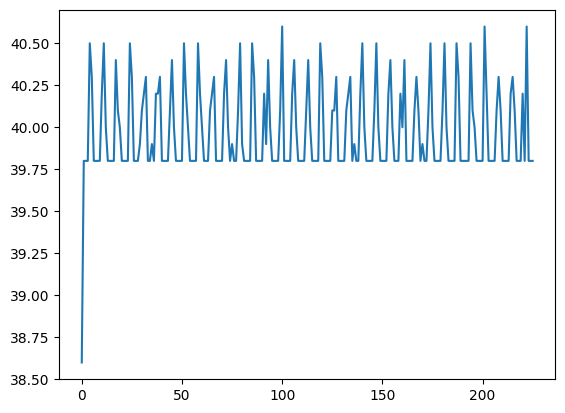

In [265]:

df_iperf[6].astype(float).plot()
plt.show()

In [266]:
df.head()

,id_node,id,type,log_creation_time,catch_time,after_preprocess_time,server_catch_time,completion_time,size,id_server
0,59d4r,1,vectorized_logs,1.710352e+09,1.710352e+09,1.710352e+09,1.710352e+09,1.710352e+09,30802,j5xs7
1,z9bx4,1,vectorized_logs,1.710352e+09,1.710352e+09,1.710352e+09,1.710352e+09,1.710352e+09,30802,j5xs7
2,zqs62,1,vectorized_logs,1.710352e+09,1.710352e+09,1.710352e+09,1.710352e+09,1.710352e+09,30802,j5xs7
3,59d4r,2,vectorized_logs,1.710352e+09,1.710352e+09,1.710352e+09,1.710352e+09,1.710352e+09,30771,j5xs7
4,bbh5g,1,vectorized_logs,1.710352e+09,1.710352e+09,1.710352e+09,1.710352e+09,1.710352e+09,30802,j5xs7


In [267]:
for id_server in df.id_server.unique():
    server_df = df[df.id_server == id_server]
    print(id_server)
    print(server_df.shape)

j5xs7
(30000, 10)


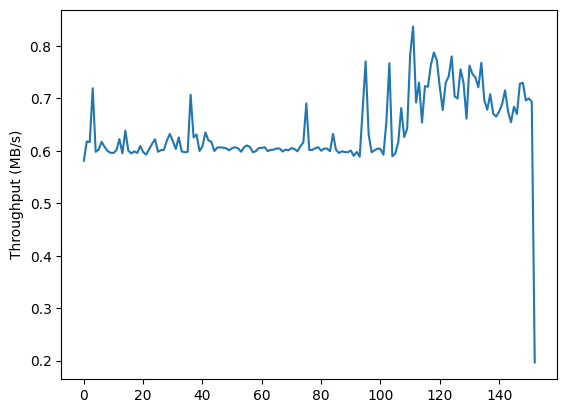

In [268]:
#get troughput
log_creation = df.log_creation_time - df.log_creation_time.min()

period = 1

log_creation = log_creation.apply(lambda x: int(x/period))

#sum size of logs per period
throughput = df.groupby(log_creation)["size"].sum()/10e6

#label y axis
plt.ylabel("Throughput (MB/s)")
plt.plot(throughput.values)

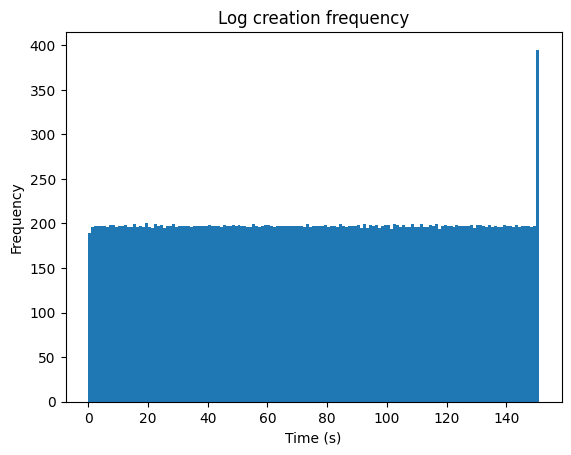

In [269]:
#get generation overall generation frequency

log_creation = df.log_creation_time - df.log_creation_time.min()

period = 1

#get number of logs generated at each period
log_creation = log_creation.apply(lambda x: int(x/period))

plt.hist(log_creation, bins=range(0,log_creation.max(),period))
plt.title("Log creation frequency")
plt.xlabel("Time (s)")
plt.ylabel("Frequency")

plt.show()


<Axes: xlabel='type'>

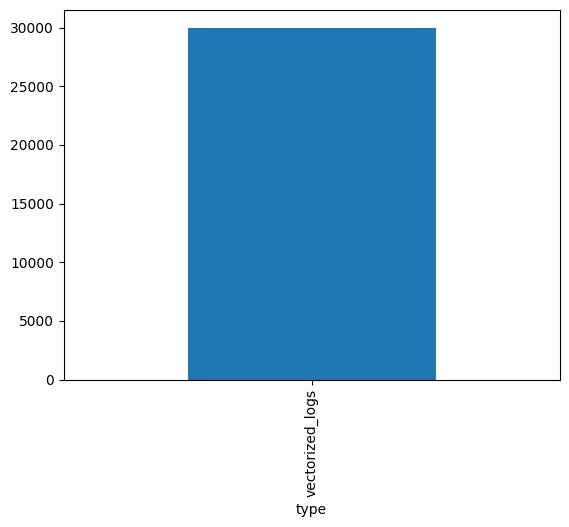

In [270]:
#counting type logs 

df["type"].value_counts().plot(kind='bar')

In [220]:
df.head()

,id_node,id,type,log_creation_time,catch_time,after_preprocess_time,server_catch_time,completion_time,size,id_server
0,8vxwv,1,vectorized_logs,1.710351e+09,1.710351e+09,1.710351e+09,1.710351e+09,1.710351e+09,30802,rdffx
1,8vxwv,2,vectorized_logs,1.710351e+09,1.710351e+09,1.710351e+09,1.710351e+09,1.710351e+09,30771,rdffx
2,5kqvf,1,vectorized_logs,1.710351e+09,1.710351e+09,1.710351e+09,1.710351e+09,1.710351e+09,30802,rdffx
3,8vxwv,3,vectorized_logs,1.710351e+09,1.710351e+09,1.710351e+09,1.710351e+09,1.710351e+09,30833,rdffx
4,g8zs6,1,vectorized_logs,1.710351e+09,1.710351e+09,1.710351e+09,1.710351e+09,1.710351e+09,30802,rdffx


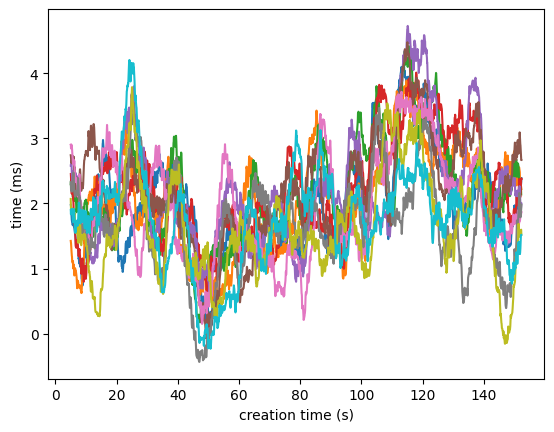

In [271]:
#get index and time for each id_node
fig, ax = plt.subplots()
for id_node in df.id_node.unique():
    node_df = df[df.id_node == id_node]
    x = node_df.log_creation_time.values - node_df.log_creation_time.values[0]
    y = (node_df.server_catch_time - node_df.after_preprocess_time)*1000 
    # y = node_df["size"].values
    # condition = y < 100
    # x = x[condition]
    # y = y[condition]
    y_mean = y.rolling(window=100).mean()
 
    # ax.scatter(x,y,s=1,zorder=1,label=node_df["type"].values[0])
    ax.plot(x,y_mean,label=node_df.type.values[0])
plt.xlabel('creation time (s)')
plt.ylabel('time (ms)')
# plt.legend()

plt.show()

In [223]:
def concatenate_df(df_list_names):
    df_list = []
    for df_name in df_list_names:
        df = pd.read_csv("data/logging_data/"+df_name)
        df["parallelism"] = int(df_name.split("_")[1])
        df_list.append(df)
    min_len = min([df.shape[0]//df["parallelism"][0] for df in df_list])
    df = pd.concat([df[:min_len*df["parallelism"][0]] for df in df_list])
    return df
        

In [ ]:
df = concatenate_df(["time10log15.txt","time10vec15.txt"])
# df = concatenate_df(["time_log64_1.txt","time_vec64_1.txt","time_ano64_1.txt"])


fig, ax = plt.subplots()
for id_node in df.id_node.unique():
    node_df = df[df.id_node == id_node]
    x = node_df.log_creation_time.values - node_df.log_creation_time.values[0]
    # y = (node_df.server_catch_time.values - node_df.after_preprocess_time.values)*1000
    y = node_df["size"].values
    #eliminate outliers
    condition = y > 0
    x = x[condition]
    y = y[condition]
    ax.scatter(x,y,s=1,zorder=1,label=node_df.type.values[0])
    # print(np.mean(y))
    
plt.xlabel('creation time (s)')
plt.ylabel('time (ms)')
plt.legend()

plt.show()

In [ ]:
df = concatenate_df(["time10log15.txt","time10vec15.txt"])
# df = concatenate_df(["time_log64_1.txt","time_vec64_1.txt","time_ano64_1.txt"])


fig, ax = plt.subplots()
for id_node in df.id_node.unique():
    node_df = df[df.id_node == id_node]
    gen_time = node_df.log_creation_time - node_df.log_creation_time[0]

    log_creation = gen_time.apply(lambda x: int(x/1))

    #sum size of logs per period
    throughput = node_df.groupby(log_creation)["size"].sum()

    # ax.scatter(x,y,s=1,zorder=1,label=node_df.type.values[0])
    plt.plot(throughput.values)
    
plt.xlabel('creation time (s)')
plt.ylabel('throughput (bytes/s)')

plt.show()

In [530]:
df.head()

,id_node,id,type,log_creation_time,catch_time,after_preprocess_time,server_catch_time,completion_time,size,id_server,parallelism
0,6lnv2,1,logs,1.710253e+09,1.710253e+09,1.710253e+09,1.710253e+09,1.710253e+09,38093,xmvxj,5
1,lgbss,1,logs,1.710253e+09,1.710253e+09,1.710253e+09,1.710253e+09,1.710253e+09,38093,xmvxj,5
2,rj7jp,1,logs,1.710253e+09,1.710253e+09,1.710253e+09,1.710253e+09,1.710253e+09,38093,xmvxj,5
3,m2r7j,1,logs,1.710253e+09,1.710253e+09,1.710253e+09,1.710253e+09,1.710253e+09,38093,xmvxj,5
4,ngvft,1,logs,1.710253e+09,1.710253e+09,1.710253e+09,1.710253e+09,1.710253e+09,38093,xmvxj,5


101.0522582689921
103.03890647093455


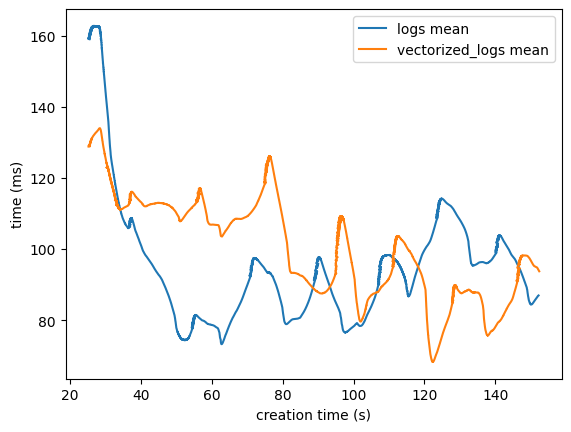

In [225]:
df = concatenate_df(["time_10_log_12_40.txt","time_10_vec_12_40.txt"])
# df = concatenate_df(["time_log64_1.txt","time_vec64_1.txt","time_ano64_1.txt"])


fig, ax = plt.subplots()
for type_log in df.type.unique():
    type_df = df[df.type == type_log]
    x = type_df.log_creation_time.values - type_df.log_creation_time.values[0]
    y = (type_df.server_catch_time - type_df.after_preprocess_time)*1000
    
    # y = type_df["size"].values
    #eliminate outliers
    # condition = y < 10
    # x = x[condition]
    # y = y[condition]
    y_mean = y.rolling(window=5000).mean()
    # ax.scatter(x,y,s=1,zorder=1,label=type_df.type.values[0])
    ax.plot(x,y_mean,label=type_df.type.values[0]+" mean")
    print(np.mean(y))
    
plt.xlabel('creation time (s)')
plt.ylabel('time (ms)')
plt.legend()

plt.show()

In [226]:
with open("data/logging_data/iperf_50_tcp_log.log") as f:
    lines = f.readlines()[6:]


df_iperf_log = pd.DataFrame([x.split() for x in lines])

with open("data/logging_data/iperf_50_tcp_vec.log") as f:
    lines = f.readlines()[6:]


df_iperf_vec = pd.DataFrame([x.split() for x in lines])

In [227]:
df_iperf_vec.head()

,0,1,2,3,4,5,6,7
0,[,5],0.00-1.00,sec,5.73,MBytes,48.1,Mbits/sec
1,[,5],1.00-2.00,sec,6.00,MBytes,50.3,Mbits/sec
2,[,5],2.00-3.00,sec,5.95,MBytes,49.9,Mbits/sec
3,[,5],3.00-4.00,sec,5.93,MBytes,49.7,Mbits/sec
4,[,5],4.00-5.00,sec,6.00,MBytes,50.3,Mbits/sec


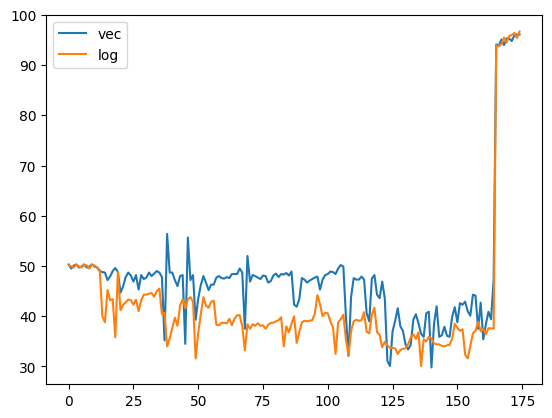

In [260]:
df_iperf_log_val = df_iperf_log[6][90:175+90].astype(float).reset_index(drop=True)


df_iperf_vec_val = df_iperf_vec[6][68:175+68].astype(float).reset_index(drop=True)


df_iperf_vec_val.plot(label="vec")
df_iperf_log_val.plot(label="log")
plt.legend()
plt.show()

36438.926
32600.790666666668


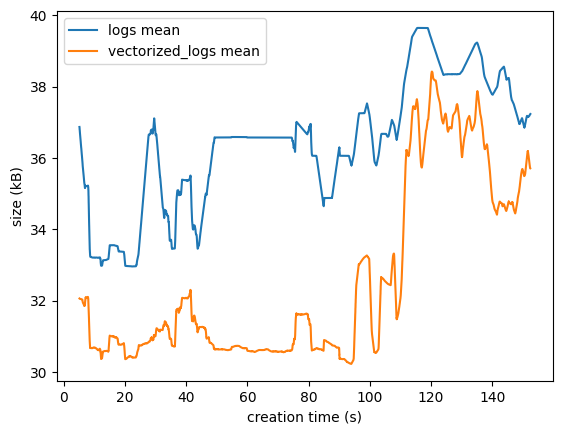

In [131]:
df = concatenate_df(["time_10_log12.txt","time_10_vec12.txt"])
# df = concatenate_df(["time_log64_1.txt","time_vec64_1.txt","time_ano64_1.txt"])


fig, ax = plt.subplots()
for type_log in df.type.unique():
    type_df = df[df.type == type_log]
    x = type_df.log_creation_time.values - type_df.log_creation_time.values[0]
    # y = (type_df.server_catch_time - type_df.after_preprocess_time)*1000
    
    y = type_df["size"]
    #eliminate outliers
    # condition = y < 10
    # x = x[condition]
    # y = y[condition]
    y_mean = y.rolling(window=1000).mean()/1e3
    # ax.scatter(x,y,s=1,zorder=1,label=type_df.type.values[0])
    ax.plot(x,y_mean,label=type_df.type.values[0]+" mean")
    print(np.mean(y))
    
plt.xlabel('creation time (s)')
plt.ylabel('size (kB)')
plt.legend()

plt.show()

In [146]:
df = pd.read_csv("data/logging_data/time_vec1.txt")
df.head()

,id_node,id,type,log_creation_time,catch_time,after_preprocess_time,server_catch_time,completion_time
0,269k7,1,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09
1,269k7,2,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09
2,269k7,3,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09
3,269k7,4,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09
4,269k7,5,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09


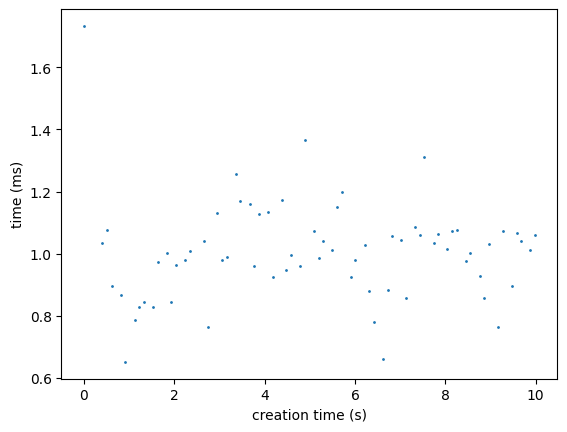

In [149]:
fig, ax = plt.subplots()
for id_node in df.id_node.unique():
    node_df = df[df.id_node == id_node][:100]
    x = node_df.log_creation_time.values - node_df.log_creation_time.values[0]
    y = (node_df.server_catch_time.values - node_df.after_preprocess_time.values)*1000 
    #eliminate outliers
    condition = y < 3
    x = x[condition]
    y = y[condition]
    ax.scatter(x,y,s=1,zorder=1)
    
plt.xlabel('creation time (s)')
plt.ylabel('time (ms)')

plt.show()

In [ ]:
fig, ax = plt.subplots()
for key in ["logs"]:
    ax.plot(data[key], label=key)
    plt.xlabel('logs')
    plt.ylabel('size [Bytes]')
    plt.legend()

plt.show()

for key in ["mean_padding"]:
    fig, ax = plt.subplots()
    plt.xlabel('steps')
    plt.ylabel(key)
    ax.plot(data[key])
    plt.show()

In [ ]:
for key in data.keys():
    fig, ax = plt.subplots()
    plt.xlabel('steps')
    plt.ylabel(key)
    ax.plot(data[key])
    plt.show()
        # fig.savefig("")

In [9]:
#testing encoding and decoding
vocab_size = 4000
max_len=60
latent_dim = max_len//2

chkpt = "data_visualization/logging_data/logs_model/"

raw_ds = ( #.filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    tf.data.TextLineDataset("persistent_volume/data/HDFS_v2/node_logs/hadoop-hdfs-datanode-mesos-01.log")
    .batch(1)
    .shuffle(buffer_size=256)
)

with open("docker_agent_logger/app/logs_tokenizer/vocab.pkl","rb") as f:
    vocab = pickle.load(f)

tokenizer = Tokenizer(vocab=vocab,max_len=max_len)

ds = raw_ds.map(tokenizer.preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

model = Model(vocab_size = vocab_size,latent_dim=latent_dim,embedding_dim=128,max_len = max_len)

model.vae.load_model(chkpt=chkpt)


# z = tf.random.normal(shape=(1, latent_dim))
# vectorized_token = ds.shuffle(buffer_size=256).take(1).as_numpy_iterator().next()

# print(tokenizer.decode(vectorized_token))

# z = model.vae.encode(vectorized_token)

# print(z)

# tokens = model.vae.decode(z)

# print(tokenizer.decode(tokens))



2023-11-14 15:24:32.273141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.520119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.520305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.529282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.529400: I tensorflow/compile

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 60)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_embedding (TokenAndP  (None, 60, 128)              519680    ['input_word_ids[0][0]']      
 ositionEmbedding)                                                                                
                                                                                                  
 encoding (TransformerEncod  (None, 60, 128)              71828     ['input_embedding[0][0]']     
 er)                                                                                        

2023-11-14 15:25:03.546239: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


100000/100000 [==============================] - 2758s 27ms/step


2023-11-14 16:10:58.230430: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13504693080879762698


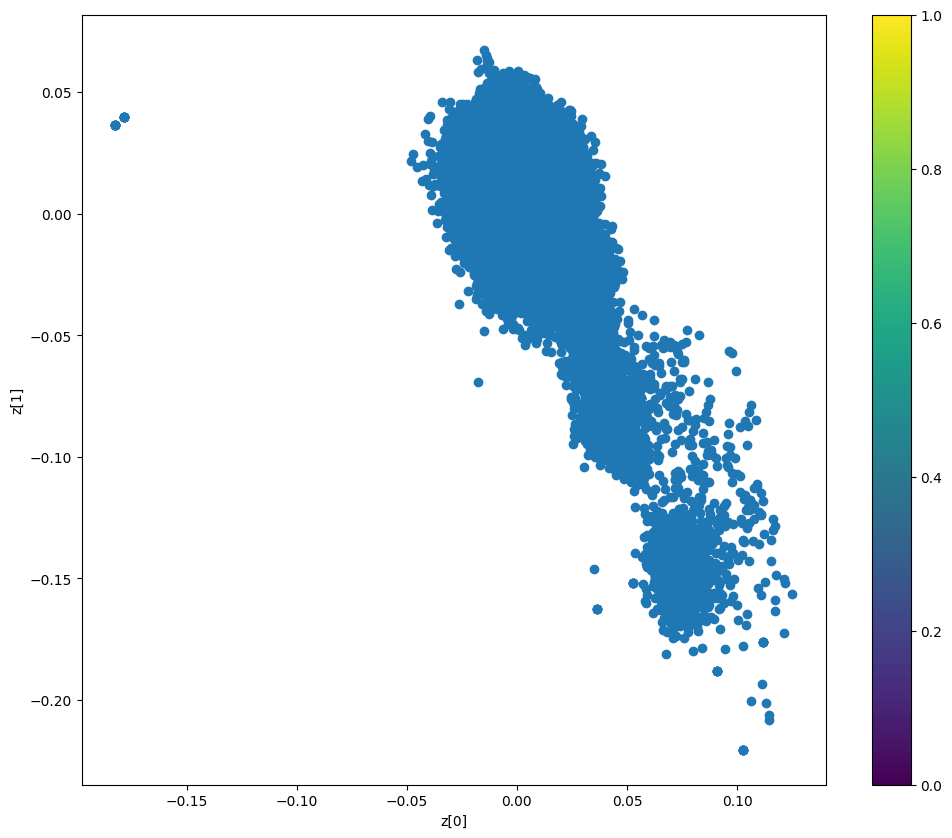

In [10]:
def plot_label_clusters(vae, name,data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig("./results/"+name+".png")
    plt.show()

# model = Model(vocab_size = vocab_size,latent_dim=latent_dim,embedding_dim=128,max_len = max_len)

# model.vae.load_model(chkpt=chkpt)
plot_label_clusters(model.vae, "cluster",ds.take(100000))


# for i in range(32):
#     model.vae.load_model(chkpt=chkpt+str(i))

#     plot_label_clusters(model.vae, "cluster"+str(i),ds)

In [49]:
raw_ds = ( #.filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    tf.data.TextLineDataset("persistent_volume/data/HDFS_v2/node_logs/hadoop-hdfs-datanode-mesos-01.log")
    .batch(64)
)

print(raw_ds.take(1).as_numpy_iterator().next())

[b'2015-12-03 14:37:47,611 INFO org.apache.hadoop.hdfs.server.datanode.DataNode: STARTUP_MSG: '
 b'/************************************************************'
 b'STARTUP_MSG: Starting DataNode'
 b'STARTUP_MSG:   host = mesos-master-1/10.10.34.11'
 b'STARTUP_MSG:   args = []' b'STARTUP_MSG:   version = 2.7.1'
 b'STARTUP_MSG:   classpath = /usr/local/hadoop/etc/hadoop:/usr/local/hadoop/share/hadoop/common/lib/commons-digester-1.8.jar:/usr/local/hadoop/share/hadoop/common/lib/activation-1.1.jar:/usr/local/hadoop/share/hadoop/common/lib/commons-configuration-1.6.jar:/usr/local/hadoop/share/hadoop/common/lib/commons-math3-3.1.1.jar:/usr/local/hadoop/share/hadoop/common/lib/api-util-1.0.0-M20.jar:/usr/local/hadoop/share/hadoop/common/lib/hamcrest-core-1.3.jar:/usr/local/hadoop/share/hadoop/common/lib/jaxb-api-2.2.2.jar:/usr/local/hadoop/share/hadoop/common/lib/slf4j-api-1.7.10.jar:/usr/local/hadoop/share/hadoop/common/lib/jetty-util-6.1.26.jar:/usr/local/hadoop/share/hadoop/common/lib/jer